# Semi-synthetic Spellmatch parameter sensitivity analysis

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

## Algorithm convergence

In [2]:
scores_info = pd.read_csv("results/scores.csv")
source_desc = scores_info["points_file_name"].str.split("[_\.]", regex=True)
df = pd.DataFrame(
    data={
        "is_dense": source_desc.str[0] == "dense",
        "is_heterogeneous": source_desc.str[1] == "heterogeneous",
        "use_degrees": scores_info["spellmatch_degree_weight"] != 0.0,
        "use_intensities": scores_info["spellmatch_intensity_weight"] != 0.0,
        "use_distances": scores_info["spellmatch_distance_weight"] != 0.0,
        "converged": scores_info["error"].isna(),
    }
)

In [3]:
x = df.drop(columns="converged")
y = df["converged"]
rfc = RandomForestClassifier(bootstrap=False, random_state=123).fit(x, y)
rfc.score(x, y)

0.9921875

In [4]:
pd.Series(rfc.feature_importances_, index=rfc.feature_names_in_, name="Gini importance").sort_values(ascending=False)

use_intensities     0.258583
is_heterogeneous    0.233360
is_dense            0.227409
use_distances       0.148178
use_degrees         0.132470
Name: Gini importance, dtype: float64

In [5]:
df.groupby("use_intensities")["converged"].mean()

use_intensities
False    0.96875
True     1.00000
Name: converged, dtype: float64

In [6]:
df.groupby(["use_intensities", "is_heterogeneous"])["converged"].mean().to_frame(name="frac_converged").reset_index()\
    .pivot(index="use_intensities", columns="is_heterogeneous", values="frac_converged")

is_heterogeneous,False,True
use_intensities,,
False,1.0,0.9375
True,1.0,1.0000


In [7]:
df.groupby(["use_intensities", "is_dense"])["converged"].mean().to_frame(name="frac_converged").reset_index()\
    .pivot(index="use_intensities", columns="is_dense", values="frac_converged")

is_dense,False,True
use_intensities,,
False,1.0,0.9375
True,1.0,1.0000


In [8]:
df.groupby(["is_dense", "is_heterogeneous"])["converged"].mean().to_frame(name="frac_converged").reset_index()\
    .pivot(index="is_dense", columns="is_heterogeneous", values="frac_converged")

is_heterogeneous,False,True
is_dense,,
False,1.0,1.00000
True,1.0,0.96875


## Assignment strategy (pre-selection)

In [9]:
df = pd.read_csv("results/results.csv")

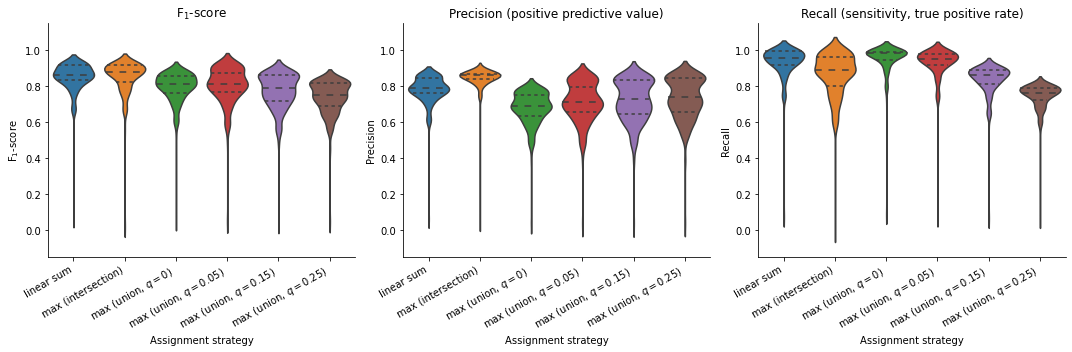

In [10]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Parameter selection

In [11]:
results_info = pd.read_csv("results/results.csv")
df = results_info[results_info["metric_name"] == "f1score"]
df = pd.DataFrame(
    data={
        "degree_weight": df["spellmatch_degree_weight"],
        "intensity_weight": df["spellmatch_intensity_weight"],
        "distance_weight": df["spellmatch_distance_weight"],
        "f1score": df["metric_value"],
    }
)

### Degree/intensity/distance weights

In [12]:
x = df.drop(columns="f1score")
y = df["f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.31975593886400744

In [13]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

degree_weight       0.448223
intensity_weight    0.332102
distance_weight     0.219675
Name: Gini importance, dtype: float64

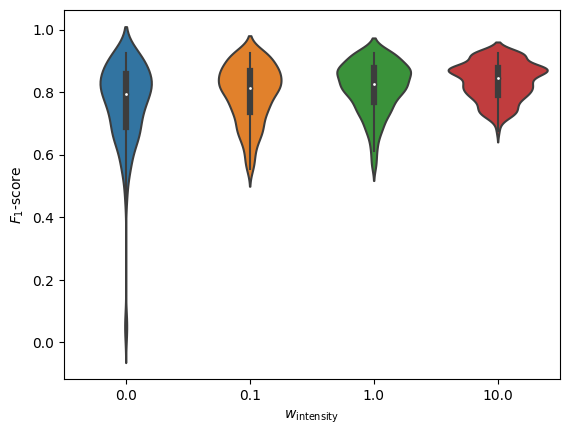

In [14]:
sns.violinplot(
    data=df,
    x="intensity_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{intensity}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{intensity} = 1$ as reference

In [15]:
x = df[df["intensity_weight"] == 1].drop(columns="f1score")
y = df.loc[df["intensity_weight"] == 1, "f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.24211164156694132

In [16]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

degree_weight       0.927672
distance_weight     0.072328
intensity_weight    0.000000
Name: Gini importance, dtype: float64

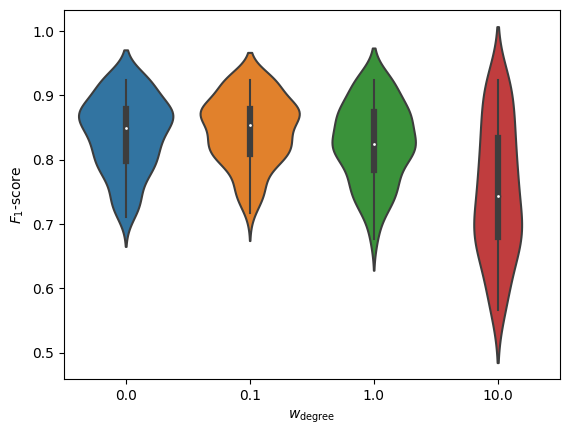

In [17]:
sns.violinplot(
    data=df[df["intensity_weight"] == 1],
    x="degree_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{degree}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{degree} = 0.1$

In [18]:
x = df[(df["intensity_weight"] == 1) & (df["degree_weight"] == 0.1)].drop(columns="f1score")
y = df.loc[(df["intensity_weight"] == 1) & (df["degree_weight"] == 0.1), "f1score"]
rfr = RandomForestRegressor(bootstrap=False, random_state=123).fit(x, y)
rfr.score(x, y)

0.006937319031193545

In [19]:
pd.Series(rfr.feature_importances_, index=rfr.feature_names_in_, name="Gini importance").sort_values(ascending=False)

distance_weight     1.0
degree_weight       0.0
intensity_weight    0.0
Name: Gini importance, dtype: float64

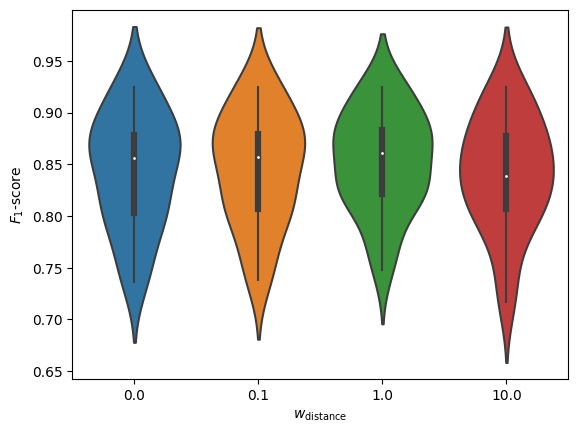

In [20]:
sns.violinplot(
    data=df[(df["intensity_weight"] == 1) & (df["degree_weight"] == 0.1)],
    x="distance_weight",
    y="f1score",
)
plt.xlabel(r"$w_\mathrm{distance}$")
plt.ylabel(r"$F_1$-score")
ax.set_ylim(-0.15, 1.15)
plt.show()

$\to$ choose $w_\text{distance} = 1$

## Assignment strategy (post-selection)

In [21]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_degree_weight"] == 0.1)
    & (results_info["spellmatch_intensity_weight"] == 1)
    & (results_info["spellmatch_distance_weight"] == 1)
]

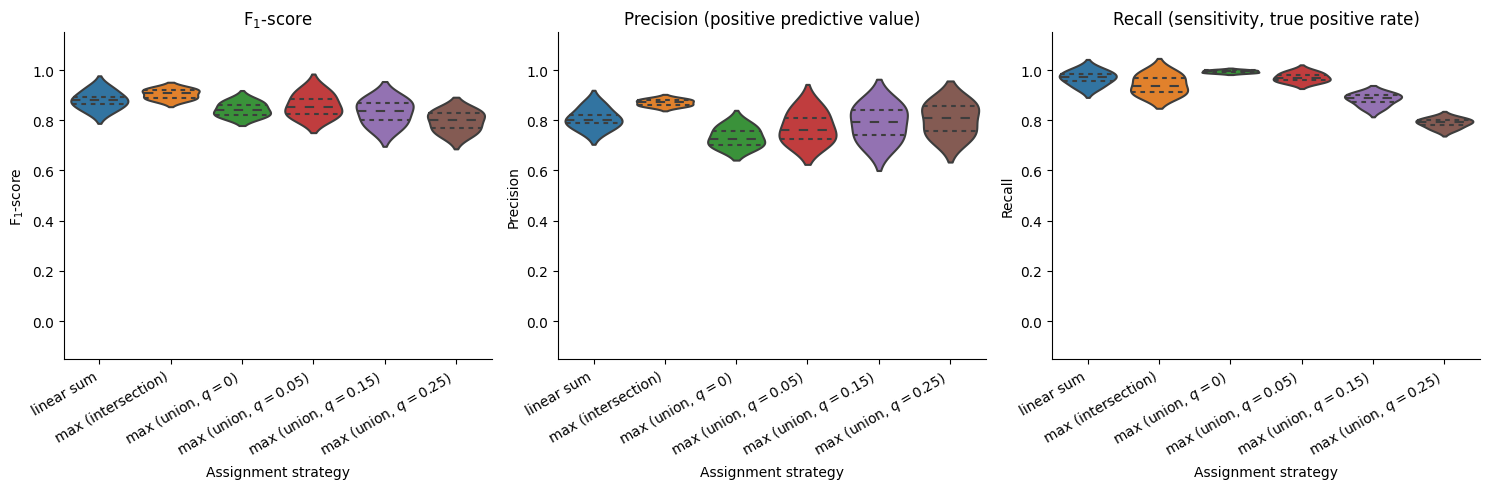

In [22]:
g = sns.catplot(
    x="assignment_name",
    y="metric_value",
    hue="assignment_name",  # avoid warning when setting sharex=False
    hue_order=[
        "linear_sum",
        "max_intersect",
        "max_union",
        "max_union_thresQ05",
        "max_union_thresQ15",
        "max_union_thresQ25",
    ],
    data=df,
    col="metric_name",
    col_order=["f1score","precision", "recall"],
    kind="violin",
    sharex=False,
    sharey=False,
    inner="quartile",
    dodge=False,  # do not dodge, despite setting hue
)
g.set_xticklabels(
    labels=[
        "linear sum",
        "max (intersection)",
        "max (union, $q=0$)",
        "max (union, $q=0.05$)",
        "max (union, $q=0.15$)",
        "max (union, $q=0.25$)",
    ],
    rotation=30,
    ha="right",
)
col_name_titles = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision (positive predictive value)",
    "recall": "Recall (sensitivity, true positive rate)",
}
col_name_ylabels = {
    "f1score": "$\\mathrm{F_1}$-score",
    "precision": "Precision",
    "recall": "Recall",
}
for col_name, ax in zip(g.col_names, g.axes.flat):
    ax.set_title(col_name_titles[col_name])
    ax.set_xlabel("Assignment strategy")
    ax.set_ylabel(col_name_ylabels[col_name])
    ax.set_ylim(-0.15, 1.15)
g.tight_layout()

## Matching performance/uncertainty

In [23]:
results_info = pd.read_csv("results/results.csv")
df = results_info[
    (results_info["spellmatch_degree_weight"] == 0.1)
    & (results_info["spellmatch_intensity_weight"] == 1)
    & (results_info["spellmatch_distance_weight"] == 1)
    & (results_info["assignment_name"] == "max_intersect")
]

In [24]:
df.pivot(index=["points_file_name"], columns="metric_name", values="metric_value")[
    [
        "f1score", "precision", "recall",
        "uncertainty_mean", "uncertainty_std",
        "margin_mean", "margin_std",
        "entropy_mean", "entropy_std",
    ]
]

metric_name,f1score,precision,recall,uncertainty_mean,uncertainty_std,margin_mean,margin_std,entropy_mean,entropy_std
points_file_name,,,,,,,,,
dense_heterogeneous.csv,0.892532,0.878586,0.906928,0.669487,0.041483,0.031394,0.021750,7.638245,2.200351
dense_homogeneous.csv,0.921765,0.883727,0.963225,0.373967,0.074892,0.085398,0.045396,8.473552,1.715900
sparse_heterogeneous.csv,0.883605,0.856796,0.912145,0.651155,0.172239,0.075696,0.072282,2.873332,2.135219
sparse_homogeneous.csv,0.920732,0.862857,0.986928,0.669508,0.269766,0.192508,0.119462,0.512165,0.401613
